In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance, ImageOps
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # Changed back to 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),  # Changed back to 128 channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),  # Changed back to 128 channels
            ResidualBlock(128),
            ResidualBlock(128)   # Added back the third residual block
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),  # Changed to match checkpoint
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),   # Changed to match checkpoint
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),    # Changed to match checkpoint
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

In [5]:
class EnhancedDRDataset(Dataset):
    def __init__(self, df, base_image_dir, label_mapping, generator_model, device, img_size=(224, 224)):
        self.df = df
        self.base_image_dir = base_image_dir
        self.label_mapping = label_mapping
        self.img_size = img_size
        self.generator = generator_model
        self.device = device
        
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
    def enhance_image(self, image):
        # Convert to PIL Image if it's not already
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
            
        # Apply GAN enhancement
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            enhanced = self.generator(img_tensor)
        
        # Convert back to image
        enhanced = enhanced.squeeze(0).cpu()
        enhanced = enhanced * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        enhanced = enhanced.clamp(0, 1)
        enhanced = transforms.ToPILImage()(enhanced)
        
        # Adjust enhancement parameters
        enhanced = ImageEnhance.Brightness(enhanced).enhance(1.1)  # Reduced enhancement
        enhanced = ImageEnhance.Contrast(enhanced).enhance(1.6)     # Reduced enhancement
        enhanced = ImageEnhance.Sharpness(enhanced).enhance(1.7)    # Reduced enhancement

        return enhanced
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row['diagnosis']
        
        # Find the image in the appropriate directory
        for label_name, label_num in self.label_mapping.items():
            img_dir = os.path.join(self.base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                # Load and enhance the image
                image = Image.open(img_path).convert('RGB')
                enhanced_image = self.enhance_image(image)
                
                # Convert to numpy array and normalize
                enhanced_array = np.array(enhanced_image)
                enhanced_array = enhanced_array / 255.0
                
                return enhanced_array, label
                
        raise FileNotFoundError(f"Image not found for id_code: {row['id_code']}")

In [6]:
def preprocess_data_with_gan(df, base_image_dir, label_mapping, generator_model, device, img_size=(224, 224)):
    images = []
    labels = []
    
    # Create an instance of EnhancedDRDataset for image enhancement
    dataset = EnhancedDRDataset(df, base_image_dir, label_mapping, generator_model, device)
    
    for index, row in df.iterrows():
        for label_name, label_num in label_mapping.items():
            img_dir = os.path.join(base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                # Get enhanced image using GAN
                image, _ = dataset[index]
                
                # Convert to cv2 format and resize
                image = (image * 255).astype(np.uint8)
                image = cv2.resize(image, img_size)
                
                images.append(image)
                labels.append(label_num)

    images = np.array(images)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=5)

    return images, labels

In [7]:
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras._tf_keras.keras.layers import (
    Conv2D, 
    MaxPooling2D, 
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization
)
from keras._tf_keras.keras.models import Sequential

def create_cnn_model(input_shape=(224, 224, 3)):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])
    
    return model

In [10]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
# Load your data
data_path = 'FGADR/train.csv'
df = pd.read_csv(data_path)
base_image_dir = 'FGADR'

# Define label mapping
label_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4
}

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5407 - loss: 17.3266 - val_accuracy: 0.7080 - val_loss: 0.8220
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7079 - loss: 0.8207 - val_accuracy: 0.7176 - val_loss: 0.8168
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7397 - loss: 0.7451 - val_accuracy: 0.7217 - val_loss: 0.7504
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7323 - loss: 0.7256 - val_accuracy: 0.7258 - val_loss: 0.7720
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7411 - loss: 0.6995 - val_accuracy: 0.7299 - val_loss: 0.7694
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7515 - loss: 0.6796 - val_accuracy: 0.7203 - val_loss: 0.7626
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7675 - loss: 0.6625 - val_accuracy: 0.7190 - val_loss: 0.7791
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7784 - loss: 0.6003 - val_accuracy: 0.7312 - 

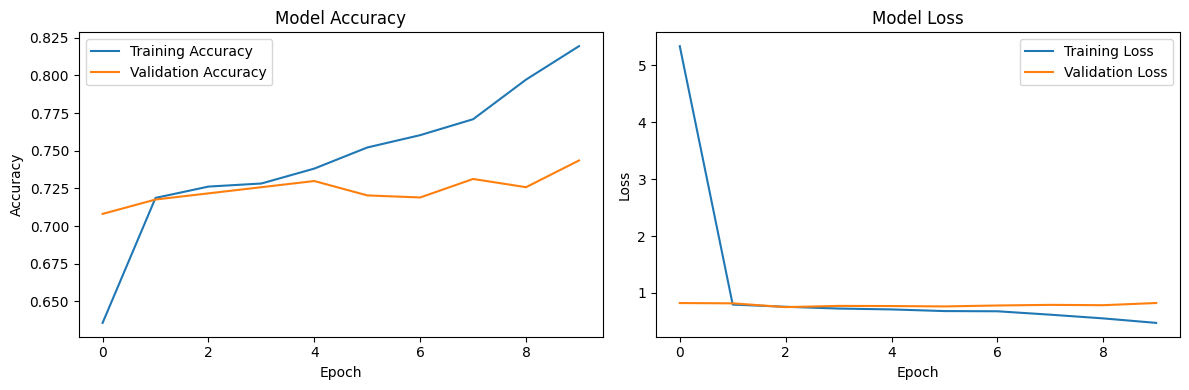

In [11]:
# Example: Modify learning rate and optimizer
import torch
from keras._tf_keras.keras.optimizers import Adam

# Set up device for GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and initialize the GAN generator
generator = Generator().to(device)
checkpoint = torch.load('enhanced_gan_models.pth', map_location=device)
generator.load_state_dict(checkpoint['model_state_dict'])
generator.eval()
# Create a new CNN model
cnn_model_tuned = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile with different learning rate and optimizer
cnn_model_tuned.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Get the preprocessed data using your existing function
images, labels = preprocess_data_with_gan(
    df=df,
    base_image_dir=base_image_dir,
    label_mapping=label_mapping,
    generator_model=generator,
    device=device
)

# Split the data
X_train_tuned, X_val_tuned, y_train_tuned, y_val_tuned = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Train the tuned CNN model
history_tuned = cnn_model_tuned.fit(
    X_train_tuned, 
    y_train_tuned, 
    epochs=10, 
    validation_data=(X_val_tuned, y_val_tuned)
)

# Plot the results
plot_training_history(history_tuned)

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step


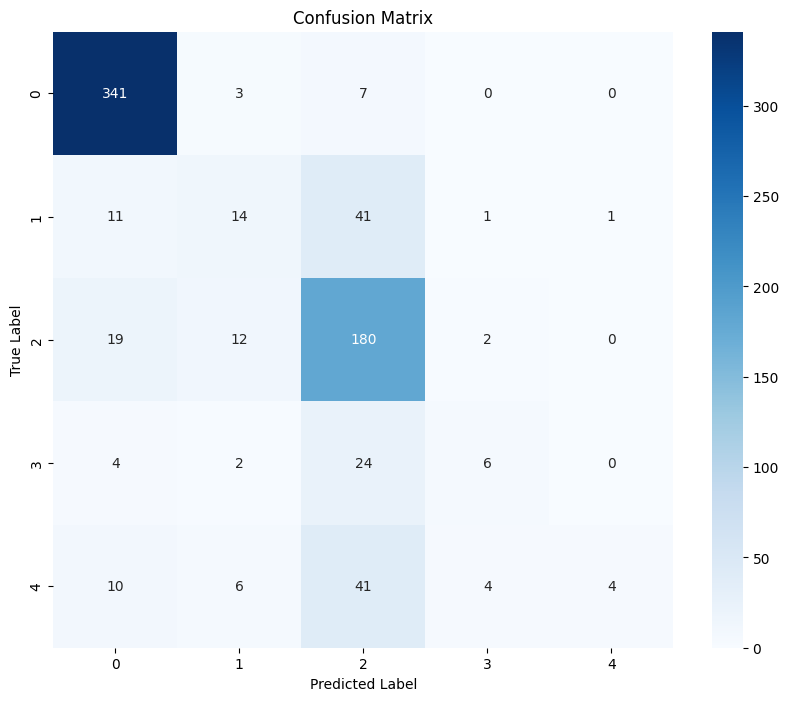

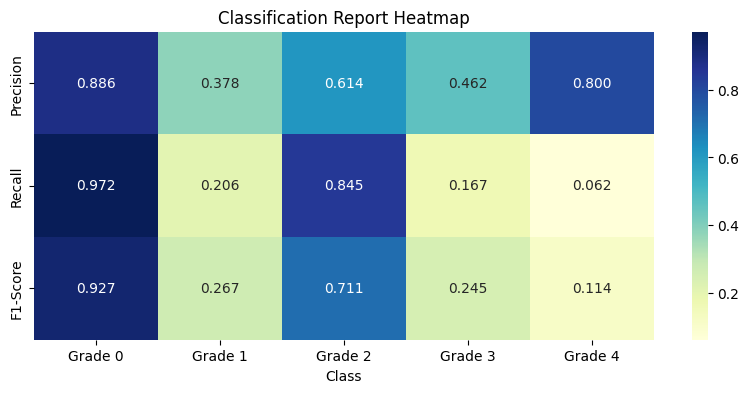

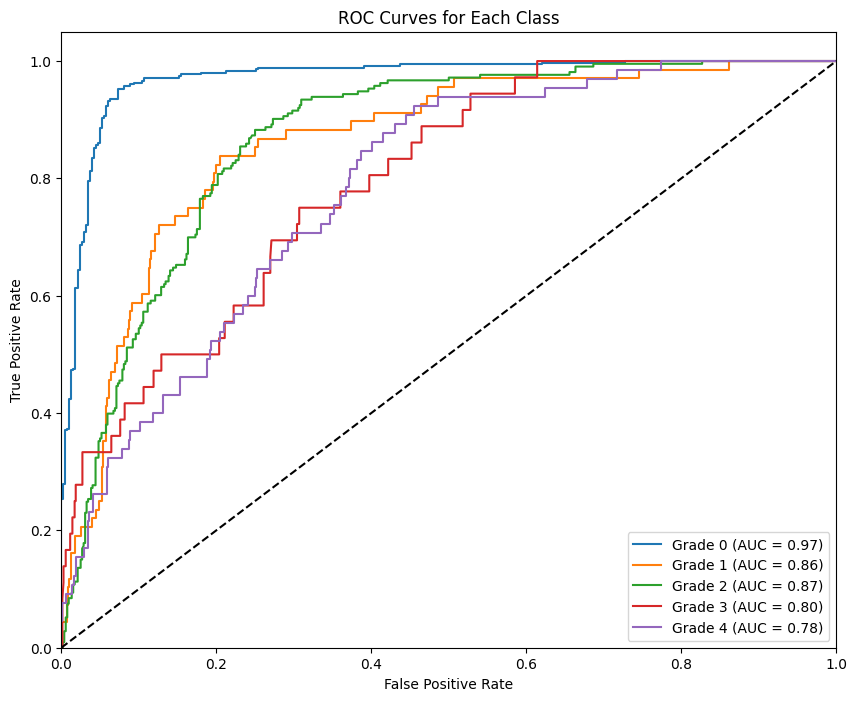

In [14]:
# ... existing code ...
# After training, get predictions
y_pred = cnn_model_tuned.predict(X_val_tuned)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_tuned, axis=1)

# Create confusion matrix plot
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot classification report as heatmap
def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Extract metrics for each class
    report_data = []
    for k, v in report.items():
        if k not in ('accuracy', 'macro avg', 'weighted avg'):
            report_data.append([k, v['precision'], v['recall'], v['f1-score']])
    
    df_report = pd.DataFrame(report_data, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
    df_report_transposed = df_report.set_index('Class').T
    
    plt.figure(figsize=(10, 4))
    sns.heatmap(df_report_transposed, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('Classification Report Heatmap')
    plt.show()

# Plot per-class metrics
class_names = ['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']
plot_classification_report(y_true_classes, y_pred_classes, class_names)

# Plot ROC curves
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 8))

for i in range(5):
    fpr, tpr, _ = roc_curve(y_val_tuned[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Grade {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step


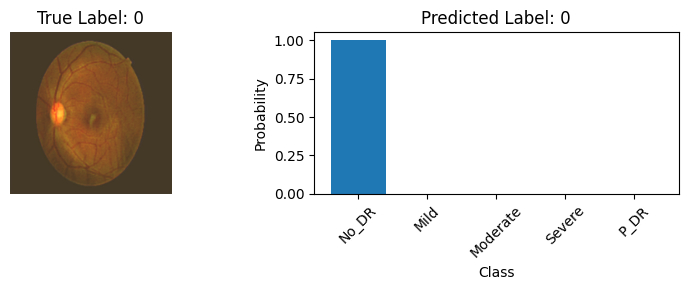

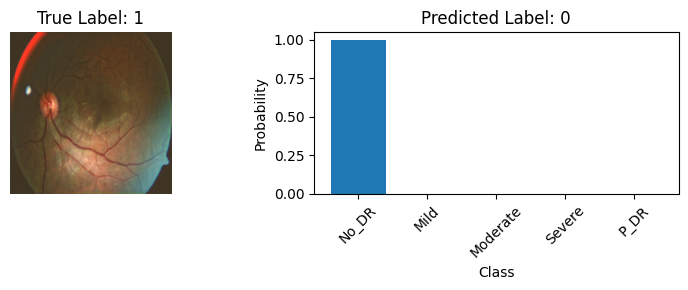

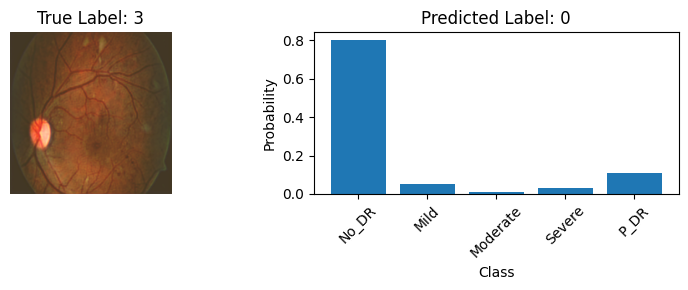

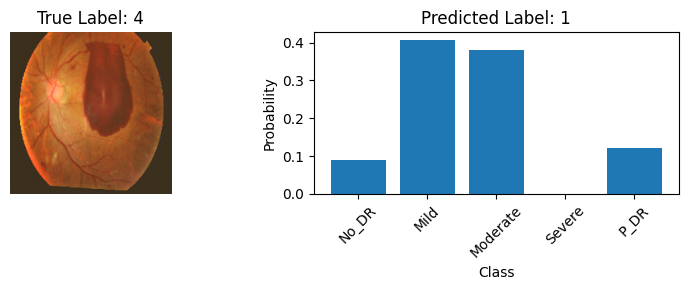

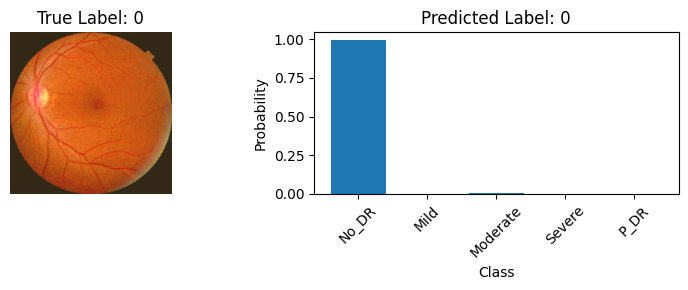

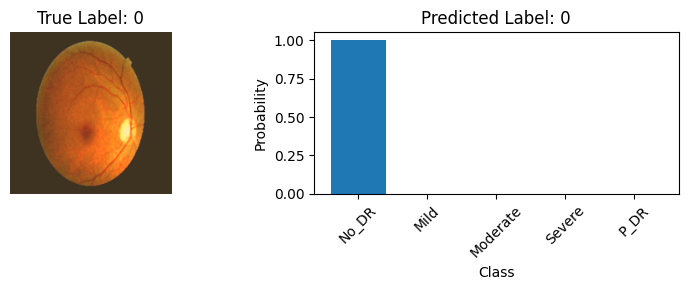

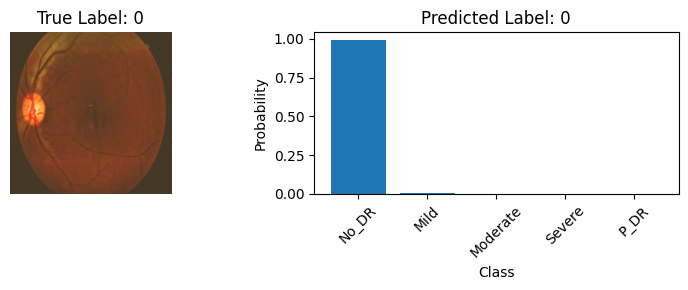

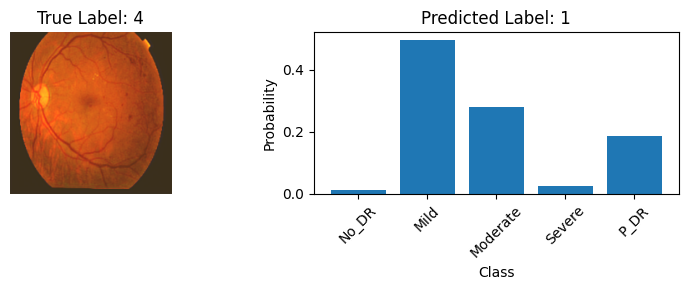

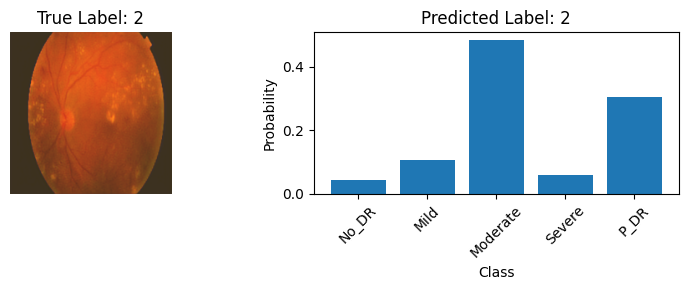

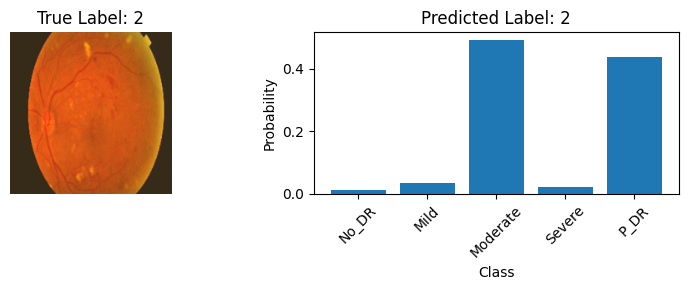

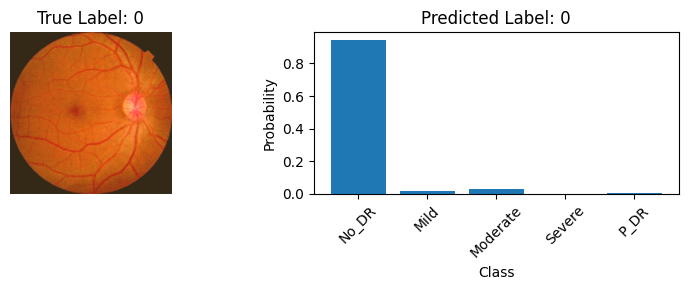

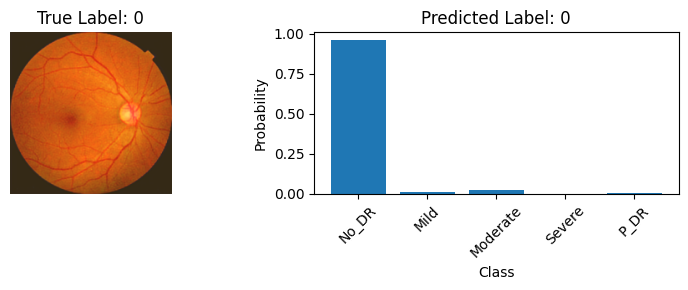

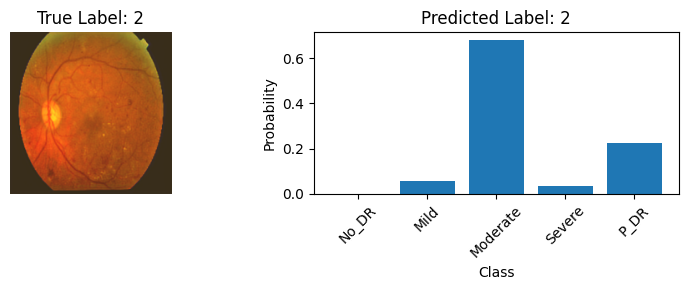

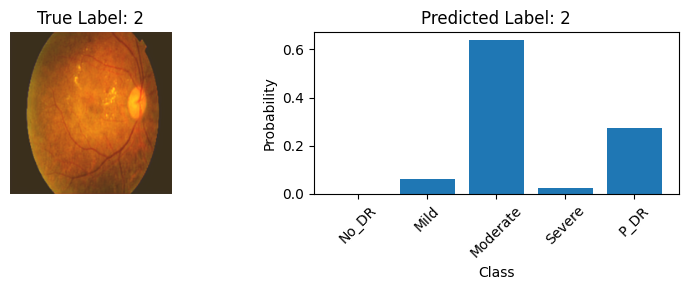

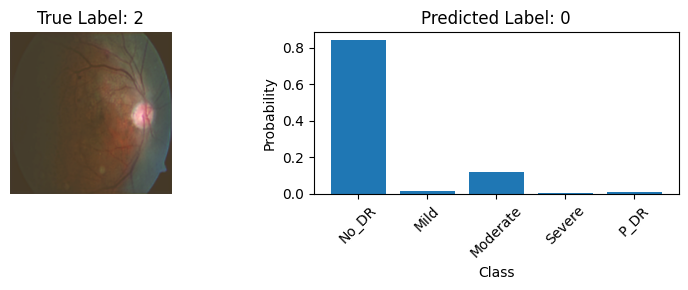

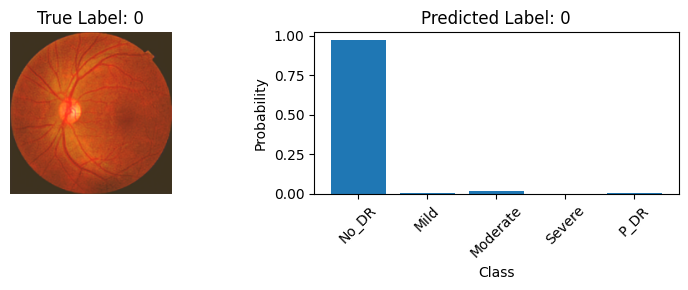

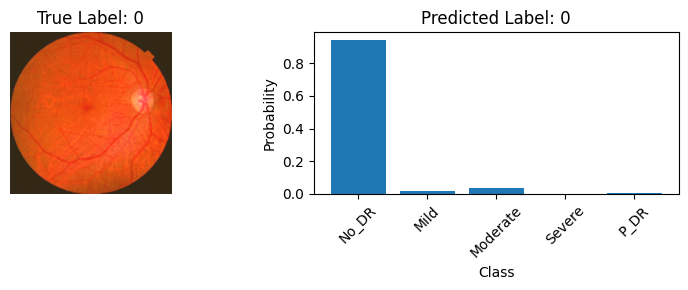

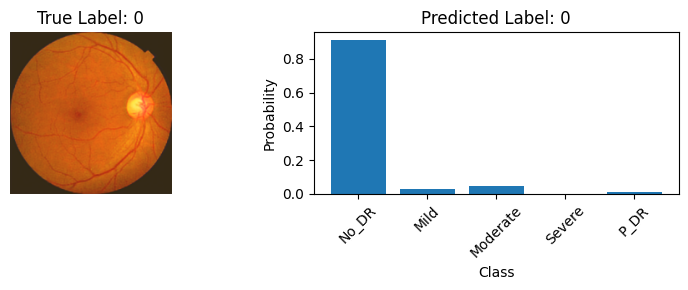

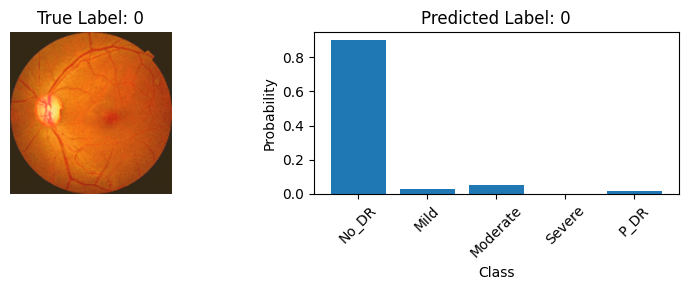

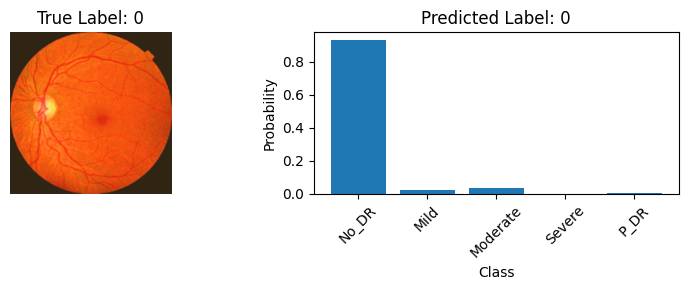

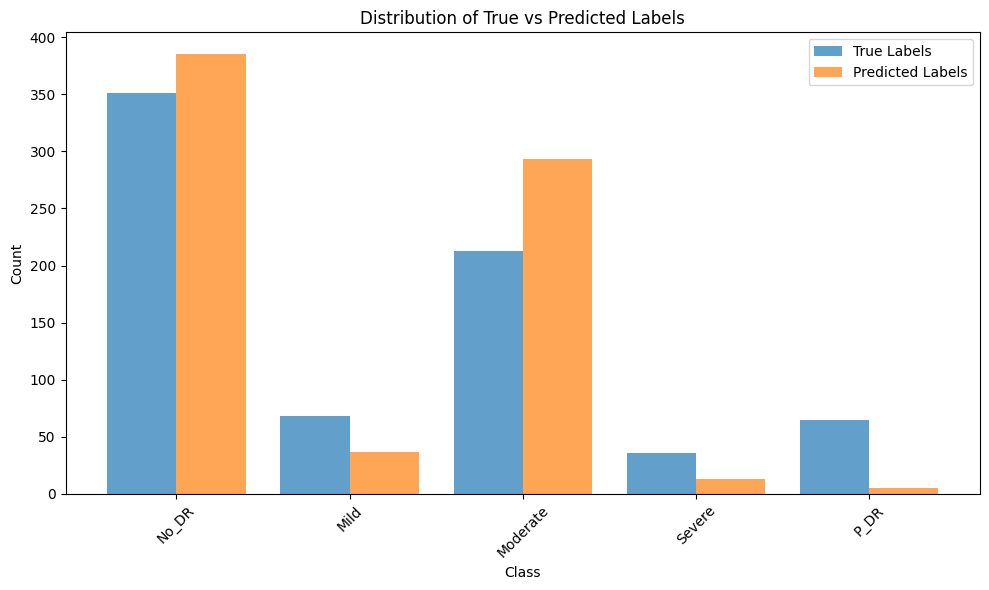

In [15]:
# Get predictions for validation data
predictions = cnn_model_tuned.predict(X_val_tuned)
predicted_classes = np.argmax(predictions, axis=1)

# Visualize test images and their predictions
num_samples_to_visualize = 20
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'P_DR']

for i in range(num_samples_to_visualize):
    plt.figure(figsize=(8, 3))
    
    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_val_tuned[i])
    plt.title(f"True Label: {np.argmax(y_val_tuned[i])}")
    plt.axis('off')
    
    # Plot prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(5), predictions[i])
    plt.xticks(range(5), class_names, rotation=45)
    plt.title(f"Predicted Label: {predicted_classes[i]}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    
    plt.tight_layout()
    plt.show()

# Additionally, let's create a summary plot of prediction distribution
plt.figure(figsize=(10, 6))
true_labels = np.argmax(y_val_tuned, axis=1)
pred_labels = predicted_classes

# Plot distribution of predictions vs true labels
plt.hist([true_labels, pred_labels], label=['True Labels', 'Predicted Labels'], 
         bins=np.arange(6)-0.5, alpha=0.7)
plt.xticks(range(5), class_names, rotation=45)
plt.title('Distribution of True vs Predicted Labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import matplotlib as plt

In [3]:
plt.figure(figsize=(10, 8))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Confusion Matrix (Percentages)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

AttributeError: module 'matplotlib' has no attribute 'figure'